#### Import libraries

In [69]:
import os
import folium

import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point, Polygon, LineString
from shapely import wkt


In [70]:
import os

PATH = '/Users/jaimesalcedovelarca/Library/CloudStorage/GoogleDrive-jaimevelarca@gmail.com/My Drive/Jaime/Geostatistic/Folium/'
RAW = PATH + 'data/raw/'
PROC = PATH + 'data/proc/'
RESULTS = PATH + 'results/'

os.chdir(PATH)

### Load working data

In [71]:
etapas = pd.read_pickle(PROC+'etapas_coords.pkl')
prospectos = pd.read_pickle(PROC+'prospectos_coords.pkl')

e1 = etapas[etapas['Etapa_x']=='E1']
e2 = etapas[etapas['Etapa_x']=='E2']
e3 = etapas[etapas['Etapa_x']=='E3']
e4 = etapas[etapas['Etapa_x']=='E4']

ustorage = pd.read_csv(PROC+'sucursales.csv')
ustorage.drop(2,inplace=True)
ustorage['coordinates'] = ustorage[['Lat','Lon']].apply(tuple,axis=1)

#### Load polygon layers

##### Municipios de Mexico

In [72]:
OPIDATA = '/Users/jaimesalcedovelarca/Library/CloudStorage/GoogleDrive-jaimevelarca@gmail.com/My Drive/Jaime/Geostatistic/FIBRA Analytics/OPI/opi-ustorage'

# Cargamos los polígonos de todos los municipios del país

pais = gpd.GeoDataFrame()

for cveedo in range(1, 33):
    cveedo = str(cveedo).zfill(2)
    estado = gpd.read_file(f'{OPIDATA}/municipio/{cveedo}')
    
    pais = pd.concat([pais, estado])

##### AGEBS

In [73]:
# Cargamos los polígonos de todas las AGEBS del país
agebs = gpd.GeoDataFrame()

for cveedo in range(1, 33):
    cveedo = str(cveedo).zfill(2)
    estado = gpd.read_file(f'{OPIDATA}/ageb/{cveedo}')

    agebs = pd.concat([agebs, estado])

In [74]:
def agebs_near_coordinates(coordenadas):
    # Coordenadas
    latitud = coordenadas[0]
    longitud = coordenadas[1]

    # Generamos un circulo para saber que estados se encuentran a la redonda
    # Radio en metros
    radio = 50000

    circulo = pd.DataFrame()

    circulo.loc[0,'geometry'] = str(Point(longitud, latitud))

    circulo['geometry'] = circulo['geometry'].apply(wkt.loads)
    circulo = gpd.GeoDataFrame(circulo,
                               crs = "EPSG:4326",
                               geometry='geometry')

    circulo = circulo.to_crs("EPSG:6372")
    circulo['geometry'] = circulo['geometry'].buffer(radio)
    circulo = circulo.to_crs("EPSG:4326")

    # Vemos que estados hay en 10km a la redonda con el fin de cargar las manzanas de los estados necesarios

    zona = gpd.sjoin(circulo, pais)[['cvemun']]

    zona['cveedo'] = zona['cvemun'].str[0:2]

    estados = zona['cveedo'].unique().tolist()

    # Cargamos las agebs de todos los estados que necesitaremos

    agebs = gpd.GeoDataFrame()

    for cveedo in estados:
        print(cveedo)
        estado = gpd.read_file(f'{OPIDATA}/ageb/{cveedo}')

        agebs = pd.concat([agebs, estado])
    return agebs


#### Obtain agebs for CMDX, GDL, MTY

In [75]:
agebs_cdmx = agebs_near_coordinates((19.41370972007067, -99.17017113141412))
agebs_mty = agebs_near_coordinates((25.702460895594644, -100.31403980850217))
agebs_gdl = agebs_near_coordinates((20.663681158024637, -103.35509879478342))

agebs = pd.concat([agebs_cdmx,agebs_gdl,agebs_mty])

15
09
13
17
19
05
14
32


In [76]:
agebs['M2_rentados'] = agebs[['M2_rentados_por_clientes_reside', 'M2_rentados_por_clientes_comerc']].sum(axis=1)
print(agebs['M2_rentados'].describe())

count    22760.000000
mean         4.752944
std         37.828856
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2229.000000
Name: M2_rentados, dtype: float64


['C' 'C-' 'E' 'AB' 'C+' 'D' 'D+' '']
Index(['ageb', 'Hogares_ABCmasC_por_km2', 'Hogares_ABCmasC', 'Flo_Ocu_ABCmasC',
       'Negocios_Modelo', 'PPM2_Local_Comercial',
       'M2_rentados_por_clientes_reside', 'M2_rentados_por_clientes_comerc',
       'NSE', 'cvemun', 'cveedo', 'Municipio', 'Estado', 'geometry',
       'M2_rentados'],
      dtype='object')
count    22760.000000
mean         4.752944
std         37.828856
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2229.000000
Name: M2_rentados, dtype: float64


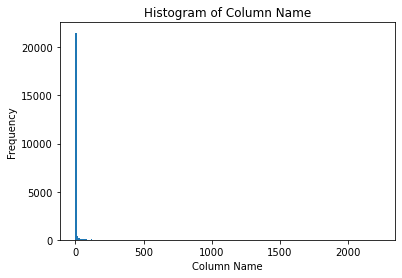

In [77]:
print(agebs['NSE'].unique())
print(agebs.columns)

print(agebs['M2_rentados'].describe())

import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(agebs['M2_rentados'], bins=200)
plt.xlabel('Column Name')
plt.ylabel('Frequency')
plt.title('Histogram of Column Name')
plt.show()

# Create map

### Define function

In [78]:
# def create_feature_group(etapa0, stage_name, color):
#     feature_group = folium.FeatureGroup(name=stage_name)
#     for index in etapa0.index:
#         feature_group.add_child(folium.Marker(
#             etapa0.loc[index, 'Coordenadas'],
#             popup=folium.Popup(etapa0.loc[index,'Calle']),
#             icon=folium.Icon(color=color,icon='eye',prefix='fa')
#         ))
#     return feature_group

In [86]:
def create_feature_group(dataframe, stage_name, color):
    feature_group = folium.FeatureGroup(name=stage_name)
    for index in dataframe.index:
        html_popup = "<b>Nombre: </b>"+str(dataframe.loc[index, 'Calle'])+"<br>"+\
        "<b>Folio: </b>"+str(dataframe.loc[index, 'Folio'])+"<br>"+\
        "<b>Tamaño m2: </b>"+str(dataframe.loc[index, 'Tamaño m2'])+"<br>"+\
        "<b>Sup. Construida: </b>"+str(dataframe.loc[index, 'Sup. Construida'])+"<br>"+\
        "<b>Precio: </b>"+str(dataframe.loc[index, 'Precio'])+"<br>"+\
        "<b>Precio x m2: </b>"+str(dataframe.loc[index, 'Precio x m2'])+"<br>"+\
        "<b>Precio x m2 const: </b>"+str(dataframe.loc[index, 'Precio x m2 const'])+"<br>"+\
        "<b>Venta/Renta: </b>"+str(dataframe.loc[index, 'Venta/Renta'])+"<br>"+\
        "<b>Uso de Suelo: </b>"+str(dataframe.loc[index, 'Uso de Suelo'])+"<br>"
        feature_group.add_child(folium.Marker(
            dataframe.loc[index, 'Coordenadas'],
            popup=folium.Popup(html=html_popup),
            tooltip=folium.Tooltip(stage_name),
            icon=folium.Icon(color=color,icon='eye',prefix='fa')
            ))
    return feature_group

### Create map

In [88]:
fibra = folium.Map(location=(19.409276288405334, -99.14712675233007),tiles='cartodb positron', zoom_start=10)

# create the feature groups for each stage
etapa1 = create_feature_group(e1, 'Etapa 1', 'green')
etapa2 = create_feature_group(e2, 'Etapa 2', 'blue')
etapa3 = create_feature_group(e3, 'Etapa 3', 'purple')
etapa4 = create_feature_group(e4, 'Etapa 4', 'red')

# Add layer for prospectos
etapa0 = folium.FeatureGroup(name='Etapa 0')
for index in prospectos.index:
    html_popup = "<b>Calle: </b>"+str(prospectos.loc[index, 'Calle'])+"<br>"+\
    "<b>Folio: </b>"+str(prospectos.loc[index, 'Folio'])+"<br>"+\
    "<b>Tamaño m2: </b>"+str(prospectos.loc[index, 'Dimensiones del predio (total en m2 del predio). Ej. 1,800m2'])+"<br>"+\
    "<b>Sup. Construida: </b>"+str(prospectos.loc[index, 'Superficie Construida'])+"<br>"+\
    "<b>Precio: </b>"+str(prospectos.loc[index, 'Valor en pesos mexicanos del total del predio.'])+"<br>"+\
    "<b>Venta/Renta: </b>"+str(prospectos.loc[index, 'Venta o renta'])+"<br>"+\
    "<b>Uso de Suelo: </b>"+str(prospectos.loc[index, 'Tipo de uso de suelo: habitacional, mixto, ...'])+"<br>"\
    "<b>Contacto: </b>"+str(prospectos.loc[index, 'Contacto nombre'])+"<br>"
    etapa0.add_child(folium.Marker(
    prospectos.loc[index, 'Coordenadas'],
    popup=folium.Popup(html=html_popup),
    tooltip=folium.Tooltip('Etapa 0'),
    icon=folium.Icon(color="lightgray",icon='eye',prefix='fa')
    ))

# for index in prospectos.index:
#     etapa0.add_child(folium.Marker(
#         location = prospectos.at[index,'Coordenadas'],
#         popup=folium.Popup(prospectos.loc[index,'Calle']),
#         icon = folium.Icon(color='lightgray',icon='question',prefix='fa')
#     ))

# add a marker for the branches
sucursales = folium.FeatureGroup(name='Sucursales')
for IX in ustorage.index:
    sucursales.add_child(folium.Marker(
        location=ustorage.loc[IX,'coordinates'],#ustorage.loc[IX,'Lon']],
        popup=folium.Popup(ustorage.loc[IX,'Sucursal']),
        tooltip=folium.Tooltip('Sucursal'),
        icon=folium.Icon(color='orange',icon='building',prefix='fa')
        ))


In [89]:

# NSE layer for counties
# Define the color map
color_map = {'E':'green','D':'green','D+':'#f2ef1d','C-':'#f2ef1d', 'C':'purple','C+':'purple','AB':'red'}

# Municipios
municipios = folium.FeatureGroup(name='Municipios')
municipios.add_child(folium.GeoJson(pais,name='NSE',style_function=lambda feature:
{'fillColor':color_map[feature['properties']['NSE']],
'color':'black',
'weight':1,
'fillOpacity':0.5}
))

# Agebs
color_map = {'E':'green','D':'green','D+':'#f2ef1d','C-':'#f2ef1d', 'C':'purple','C+':'purple','AB':'red','':'#f7f7f2'}

agebs_layer = folium.FeatureGroup(name='Areas Geograficas Basicas')
agebs_layer.add_child(folium.GeoJson(agebs,name='NSE',style_function=lambda feature:
{'fillColor':color_map[feature['properties']['NSE']],
'color':'black',
'weight':1,
'fillOpacity':.75}
)) 

In [90]:
# M2 rentados layer
variable = 'M2_rentados'

colors = ['#e6d8d8','#de807c','#d95752','#db2e27','#6e1a17']
colors_dic = {'Muy bajo':'#e6d8d8','Bajo':'#de807c','Intermedio':'#d95752','Medio-alto':'#db2e27','Alto':'#6e1a17','N/A':'#ffffff'}
bins = [0,5,10,20,100,agebs[variable].max()]
labels = ['Muy bajo','Bajo','Intermedio','Medio-alto','Alto']
agebs['range'] = pd.cut(agebs[variable],bins=bins,labels=labels)
#agebs_cdmx['range'].fillna(value='N/A',inplace=True)
print(agebs['range'].unique())

[NaN, 'Bajo', 'Intermedio', 'Muy bajo', 'Medio-alto', 'Alto']
Categories (5, object): ['Muy bajo' < 'Bajo' < 'Intermedio' < 'Medio-alto' < 'Alto']


In [91]:

metros = folium.FeatureGroup(name='Metros rentados')
metros.add_child(folium.GeoJson(agebs, name='Metros rentados', style_function=lambda feature: {
    'fillColor': colors_dic.get(feature['properties']['range'],'black'),
    'weight': 1,
    'fillOpacity': 0.6}
))

In [85]:

# add the feature groups to the map
etapa1.add_to(fibra)
etapa2.add_to(fibra)
etapa3.add_to(fibra)
etapa4.add_to(fibra)
etapa0.add_to(fibra)
sucursales.add_to(fibra)
municipios.add_to(fibra)
agebs_layer.add_to(fibra)
metros.add_to(fibra)


folium.LayerControl(position='topleft', overlay=True).add_to(fibra)

fibra.save(RESULTS+'mapa_prospectos_ciudades_info.html')